In [75]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np 
import time 
import random
import IPython.display as ipd
import pyaudio
import sys
import librosa
import librosa.display
from tqdm import tqdm
from matplotlib import pyplot as plt
sys.path.append('../../')

import pdb
#import utils.audio as a
#import utils.plots as plots
import utils as utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# load (fe)male audio sequences without alpha, beta 
PATH = '../../datasets/freesound.org/wav/'
SR = 22050 

dataset = utils.audio.loadAudioFiles(PATH, SR)
dataset_chunks = utils.audio.createAudioChunks(dataset, 100, SR)
dataset.shape, dataset_chunks.shape

100%|██████████| 383/383 [00:00<00:00, 695.67it/s]


((383,), (383,))

In [7]:
# load feature database 
# load mfcc/features databank according to num_length
PATH = '../../datasets/freesound.org/' #/wav/'
SR = 22050 

#files = os.listdir(PATH + "mfcc/")
files = os.listdir(PATH + "features/")
feat_database = []
for f in tqdm(files):
    #pdb.set_trace()
    #mfcc_database.append(np.load(PATH + "mfcc/" + f))    
    feat_database.append(np.load(PATH + "features/" + f))
feat_database = np.asarray(feat_database)
feat_database.shape


FileNotFoundError: [Errno 2] No such file or directory: '../../../datasets/freesound.org/features/'

In [51]:
chunk_feat = []
chunk_feat_sub = []
chunk_feat_vec = []
num_feats = 20
num_chunks = dataset_chunks.shape[0]
for i in tqdm(range(dataset_chunks.shape[0])):
    chunk_feat_sub = []
    for j in range(dataset_chunks[i].shape[0]):
        #pdb.set_trace()
        feat = librosa.feature.mfcc(y=dataset_chunks[i][j], sr=SR, n_mfcc=num_feats)[1:num_feats]
        chunk_feat_sub.append(feat)
        chunk_feat_vec.append(feat)
    chunk_feat.append(chunk_feat_sub)

chunk_feat = np.asarray(chunk_feat)
chunk_feat_vec = np.asarray(chunk_feat_vec)
#create length vector
len_vec = np.array([len(dataset_chunks[x]) for x in range(len(dataset_chunks))])

100%|██████████| 383/383 [01:02<00:00,  6.16it/s]


In [25]:
len_vec.shape, chunk_feat.shape, chunk_feat_vec.reshape(chunk_feat_vec.shape[0], -1).shape

((383,), (383,), (32340, 95))

In [26]:
import numpy as np
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#X_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)
X_scaled = chunk_feat_vec.reshape(chunk_feat_vec.shape[0], -1)
#x_pca = PCA(n_components=2).fit_transform(X_scaled)
np.random.seed(42)
#model = hmm.GaussianHMM(n_components=3, covariance_type="diagonal", n_iter=100)
model = hmm.GaussianHMM(n_components=3, verbose=True, covariance_type="full", n_iter=100)
#model.fit(np.array(x_pca), len_vec)
model.fit(np.array(X_scaled), len_vec)

import pickle
with open("hmm_feat_20_100ms.pkl", "wb") as file: pickle.dump(model, file)

         1   -10181755.3373             +nan
         2   -10050330.6652     +131424.6721
         3    -9891685.5648     +158645.1004
         4    -9869532.1560      +22153.4088
         5    -9858630.9953      +10901.1607
         6    -9851862.6461       +6768.3492
         7    -9847621.1857       +4241.4604
         8    -9844934.6481       +2686.5376
         9    -9843277.6303       +1657.0178
        10    -9842186.5040       +1091.1263
        11    -9841508.0375        +678.4665
        12    -9841024.5331        +483.5044
        13    -9840639.3452        +385.1879
        14    -9840269.0239        +370.3213
        15    -9839889.5862        +379.4377
        16    -9839079.8627        +809.7235
        17    -9837905.6833       +1174.1794
        18    -9836970.2852        +935.3981
        19    -9836391.5961        +578.6892
        20    -9836100.8467        +290.7494
        21    -9835897.8283        +203.0184
        22    -9835729.9290        +167.8993
        23

In [239]:
audio_idx = 76#50
chunks = np.asarray(chunk_feat[audio_idx])
print(chunks.shape)
Z2 = model.predict(chunks.reshape(chunks.shape[0], -1))

idx_cluster0 = np.where(Z2==0)

print(Z2, chunks[1].reshape(1, -1).shape)
chunk_sz = int(0.100*SR)
#print(dataset[audio_idx][(idx_cluster0[0][0]-1)*chunk_sz:idx_cluster0[0][0]*chunk_sz].shape)
#print(dataset[audio_idx].shape)
#print(dataset[audio_idx][idx_cluster0[0]*chunk_sz:idx_cluster0[0]*chunk_sz].shape)
#utils.audio.playSingleAudio(dataset[audio_idx][(idx_cluster0[0][3]-1)*chunk_sz:idx_cluster0[0][3]*chunk_sz])

(20, 19, 5)
[1 2 2 2 2 2 2 0 2 2 2 2 2 2 2 0 2 2 0 0] (1, 95)


In [240]:
idx_cluster0 = np.where(Z2==0)
is_cluster0 = (Z2!=0).astype(int) 
is_cluster0

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0])

In [246]:
lst = np.array([1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1])
lst = is_cluster0
lst_diff = np.diff(lst)
chunks.shape

(20, 19, 5)

In [245]:
chunk_sz = int(0.100*SR)
chunks = np.asarray(chunk_feat[audio_idx])
# hmm model, noise cluster ID, Chunk Size: chunk length in s * SR, audio as np.array
audio_denoised = utils.audio.removeNoise(model, 0, chunk_sz, chunks, dataset[audio_idx])
display(utils.audio.playSingleAudio(dataset[audio_idx]))
display(utils.audio.playSingleAudio(audio_denoised))


In [207]:
dataset[idx][z_idx*chunk_sz:]

array([0.04248047, 0.03704834, 0.03260803, ..., 0.0015564 , 0.00120544,
       0.00099182], dtype=float32)

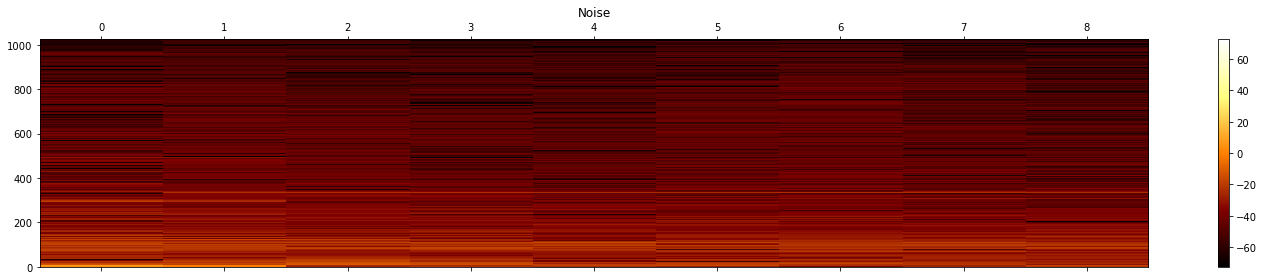

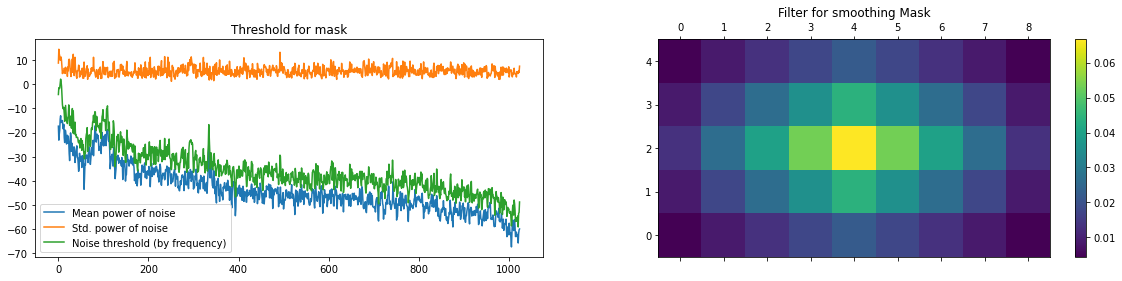

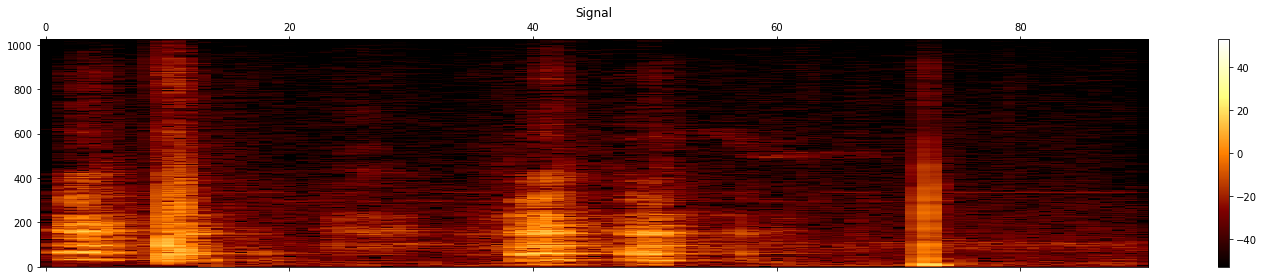

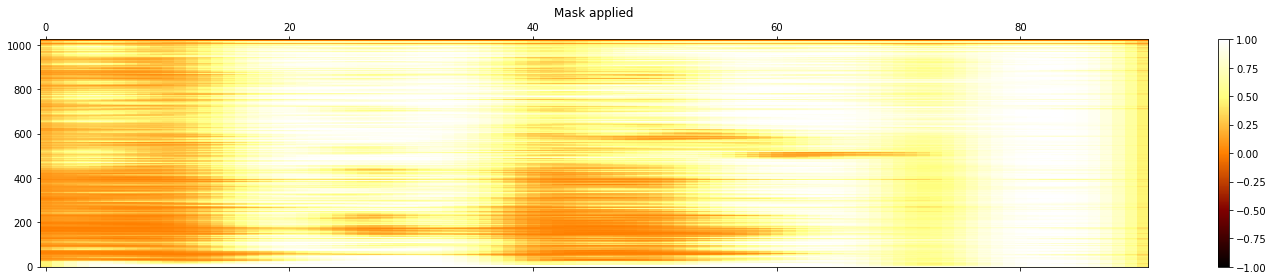

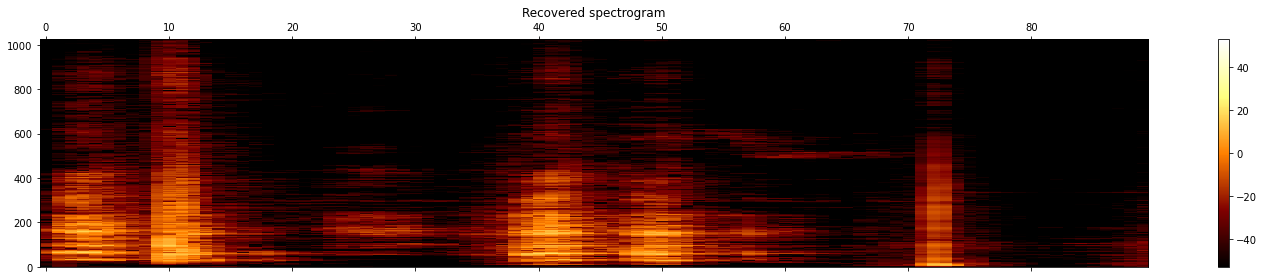

In [220]:
import noisereduce as nr
# load data
data = dataset[audio_idx]
# select section of data that is noise
noisy_part = dataset[audio_idx][(z_idx-1)*chunk_sz:(z_idx+z_len-1)*chunk_sz]
# perform noise reduction
reduced_noise = nr.reduce_noise(audio_clip=data, noise_clip=noisy_part, verbose=True)

In [244]:
display(utils.audio.playSingleAudio(dataset[audio_idx]))
display(utils.audio.playSingleAudio(reduced_noise))

